In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode


## Imbalanced dataset

In [2]:
df = pd.read_csv('pd_EEG_features.csv')
df.head()

,id,gender,PPE,EEG,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


In [3]:
X = df.drop(columns=['id','class']) 
y = df['class']  

# UNBALANCED DATA

In [4]:
count0=0
count1=0
for i in y:
    if i==0:
        count0+=1
    else:
        count1+=1

print(count0,count1)

192 564


In [6]:
#splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
#XGBoost 
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xg_accuracy = accuracy_score(y_test, y_pred)


In [8]:
#AdaBoost
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
AB_accuracy = accuracy_score(y_test, y_pred)

C:\Users\sudha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [9]:
#GBM
gbm = GradientBoostingClassifier(
    n_estimators=100,      
    learning_rate=0.05,
    max_depth=5,          
    max_features=0.9,
    random_state=42
)
gbm.fit(X_train, y_train)

y_pred_prob = gbm.predict_proba(X_test)[:, 1]
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred_prob]
gbm_accuracy = accuracy_score(y_test, y_pred_binary)

In [11]:
#LightGBM
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}
gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval)
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]
lgbm_accuracy = accuracy_score(y_test, y_pred_binary)

[LightGBM] [Info] Number of positive: 450, number of negative: 154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 150492
[LightGBM] [Info] Number of data points in the train set: 604, number of used features: 753
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.745033 -> initscore=1.072295
[LightGBM] [Info] Start training from score 1.072295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [12]:
#GMM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_scaled)
cluster_labels = gmm.predict(X_scaled)

def map_cluster_labels(true_labels, cluster_labels):
    new_labels = np.zeros_like(cluster_labels)
    for i in range(np.max(cluster_labels) + 1):
        mask = (cluster_labels == i)
        new_labels[mask] = mode(true_labels[mask])[0]
    return new_labels

true_labels = y  
mapped_labels = map_cluster_labels(true_labels, cluster_labels)
gmm_accuracy = accuracy_score(true_labels, mapped_labels)

### Accuracy on UNBALANCED data

In [14]:
print(f'XGBoost Accuracy: {xg_accuracy}')
print(f'AdaBoost Accuracy: {AB_accuracy}')
print(f'GBM Accuracy: {gbm_accuracy}')
print(f'LightGBM Accuracy: {lgbm_accuracy}')
print(f'GMM Accuracy: {gmm_accuracy}')

XGBoost Accuracy: 0.881578947368421
AdaBoost Accuracy: 0.8947368421052632
GBM Accuracy: 0.8486842105263158
LightGBM Accuracy: 0.8947368421052632
GMM Accuracy: 0.746031746031746


# BALANCED DATA

## Balancing the dataset

In [15]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
df_resampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['class'])], axis=1)

In [16]:
df_resampled

,gender,PPE,EEG,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,1,0.852470,0.718260,0.572270,240,239,0.008064,0.000087,0.002180,0.000018,...,1.562000,2.644500,3.868600,4.210500,5.122100,4.462500,2.620200,3.000400,18.940500,1
1,1,0.766860,0.694810,0.539660,234,233,0.008258,0.000073,0.001950,0.000016,...,1.558900,3.610700,23.515500,14.196200,11.026100,9.508200,6.524500,6.343100,45.178000,1
2,1,0.850830,0.676040,0.589820,232,231,0.008340,0.000060,0.001760,0.000015,...,1.564300,2.330800,9.495900,10.745800,11.017700,4.806600,2.919900,3.149500,4.766600,1
3,0,0.411210,0.796720,0.592570,178,177,0.010858,0.000183,0.004190,0.000046,...,3.780500,3.566400,5.255800,14.040300,4.223500,4.685700,4.846000,6.265000,4.060300,1
4,0,0.327900,0.797820,0.530280,236,235,0.008162,0.002669,0.005350,0.000044,...,6.172700,5.841600,6.080500,5.762100,7.781700,11.689100,8.210300,5.055900,6.116400,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,0,0.846790,0.672417,0.462422,504,503,0.003835,0.000061,0.000767,0.000003,...,8.647863,4.877069,4.029061,3.721892,3.927724,4.420524,4.450813,4.594596,4.238312,0
1124,0,0.830738,0.696754,0.353928,440,439,0.004385,0.000032,0.000781,0.000003,...,54.538588,52.496380,36.303025,22.949557,15.209481,12.072220,14.473528,14.720977,29.266257,0
1125,0,0.822565,0.563505,0.413189,493,492,0.003914,0.000045,0.000547,0.000002,...,86.697327,58.214193,47.425700,39.920400,31.880980,26.469694,19.636002,10.795145,3.076334,0
1126,0,0.787599,0.609335,0.207256,594,593,0.003245,0.000033,0.000373,0.000001,...,188.246003,146.915555,79.392584,38.204836,31.944149,30.986111,13.733797,9.864585,13.058255,0


In [17]:
type(y)

pandas.core.series.Series

In [18]:
X = df_resampled.drop(columns=['class']) 
y = df_resampled['class']  

In [19]:
count0=0
count1=0
for i in y:
    if i==0:
        count0+=1
    else:
        count1+=1

In [20]:
print(count0,count1)

564 564


### Splitting the BALANCED Data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### XGBoost on BALANCED data

In [22]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

### Accuracy on XGBoost

In [24]:
y_pred = model.predict(X_test)
xgbB_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {xgbB_accuracy}')

Accuracy: 0.9424778761061947


### AdaBoost on BALANCED data

In [25]:
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)

C:\Users\sudha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=100, random_state=42)

### Accuracy on AdaBoost

In [26]:
y_pred = ada.predict(X_test)
abB_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {abB_accuracy}')

Accuracy: 0.9513274336283186


### GBM on BALANCED Data

In [28]:
gbm = GradientBoostingClassifier(
    n_estimators=100,     
    learning_rate=0.05,
    max_depth=5,           
    max_features=0.9,
    random_state=42
)

gbm.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.05, max_depth=5, max_features=0.9,
                           random_state=42)

### Accuracy on GBM

In [29]:
y_pred_prob = gbm.predict_proba(X_test)[:, 1]
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred_prob]
gbmB_accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {gbmB_accuracy}')

Accuracy: 0.9424778761061947


### LightGBM on BALANCED data

In [30]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval)

[LightGBM] [Info] Number of positive: 447, number of negative: 455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191489
[LightGBM] [Info] Number of data points in the train set: 902, number of used features: 753
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495565 -> initscore=-0.017739
[LightGBM] [Info] Start training from score -0.017739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


### Accuracy on LightGBM

In [31]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]
lgbmB_accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {lgbmB_accuracy}')

Accuracy: 0.9734513274336283


### GMM on BALANCED data

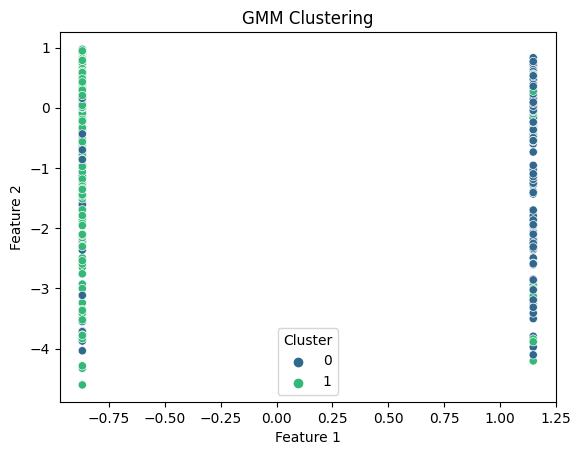

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_scaled)
cluster_labels = gmm.predict(X_scaled)

sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=cluster_labels, palette='viridis')
plt.title('GMM Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster')
plt.show()

### Accuracy on GMM

In [33]:
def map_cluster_labels(true_labels, cluster_labels):
    new_labels = np.zeros_like(cluster_labels)
    for i in range(np.max(cluster_labels) + 1):
        mask = (cluster_labels == i)
        new_labels[mask] = mode(true_labels[mask])[0]
    return new_labels

In [34]:
true_labels = y  
mapped_labels = map_cluster_labels(true_labels, cluster_labels)
gmmB_accuracy = accuracy_score(true_labels, mapped_labels)
print(f'Accuracy: {gmmB_accuracy}')

Accuracy: 0.7313829787234043


### Accuracy using BALANCED data

In [36]:
print(f'XGBoost Accuracy: {xgbB_accuracy}')
print(f'AdaBoost Accuracy: {abB_accuracy}')
print(f'GBM Accuracy: {gbmB_accuracy}')
print(f'LightGBM Accuracy: {lgbmB_accuracy}')
print(f'GMM Accuracy: {gmmB_accuracy}')

XGBoost Accuracy: 0.9424778761061947
AdaBoost Accuracy: 0.9513274336283186
GBM Accuracy: 0.9424778761061947
LightGBM Accuracy: 0.9734513274336283
GMM Accuracy: 0.7313829787234043
